# Decompilation Quality Profile — Gold Set

The decompiler is the last pipeline stage before LLM evaluation.
Its output quality directly bounds what the model can recover.
This notebook characterizes the decompiled code quality for
**GOLD-tier** (high-confidence) functions only.

### Metrics

- **CFG completeness**: Classification of control-flow-graph fidelity.
  `HIGH` = all branches resolved; `MEDIUM` = partial; `LOW` = degraded.

- **Placeholder type rate**: Fraction of variables with unresolved types.
  In stripped binaries, Ghidra infers types from usage patterns:
  $$r_{\text{type}} = \frac{|\text{placeholder-typed vars}|}{|\text{total vars}|} \in [0, 1]$$
  Lower is better.

- **Instruction-to-C ratio**: Assembly instructions per decompiled C line.
  Measures decompiler compression efficiency:
  $$r_{\text{insn:C}} = \frac{|\text{asm instructions}|}{|\text{C lines}|}$$
  Values near 1.0 indicate tight decompilation; high values may indicate
  complex control flow or loop unrolling.

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, str(Path("../..").resolve()))
from data.loader import load_ghidra_dataset

# ── Config ────────────────────────────────────────────────────────────
SELECTED_TESTS = None
OPT_LEVELS = ["O0", "O1", "O2", "O3"]

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)

OPT_COLORS = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}
CFG_COLORS = {"HIGH": "#66c2a5", "MEDIUM": "#fc8d62", "LOW": "#e41a1c"}

FIG_DIR = Path("../../figures/decompiler_quality")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  -> saved {FIG_DIR / name}.{{pdf,png}}")

# ── Load & filter to GOLD ─────────────────────────────────────────────
gds = load_ghidra_dataset(test_cases=SELECTED_TESTS, opt_levels=OPT_LEVELS)
df_all = gds.functions
df = df_all[df_all["confidence_tier"] == "GOLD"].copy()
print(f"GOLD functions: {len(df)} / {len(df_all)} total ({len(df)/len(df_all):.1%})")
print(f"By opt: {df.groupby('opt').size().to_dict()}")

GOLD functions: 495 / 1792 total (27.6%)
By opt: {'O0': 197, 'O1': 121, 'O2': 92, 'O3': 85}


---
## 1. CFG Completeness

Stacked bar showing the fraction of GOLD functions with HIGH / MEDIUM / LOW
CFG completeness at each optimization level. The HC gate requires CFG $\neq$ LOW,
so all GOLD functions should be HIGH or MEDIUM.

  -> saved ..\..\figures\decompiler_quality\cfg_completeness_gold.{pdf,png}


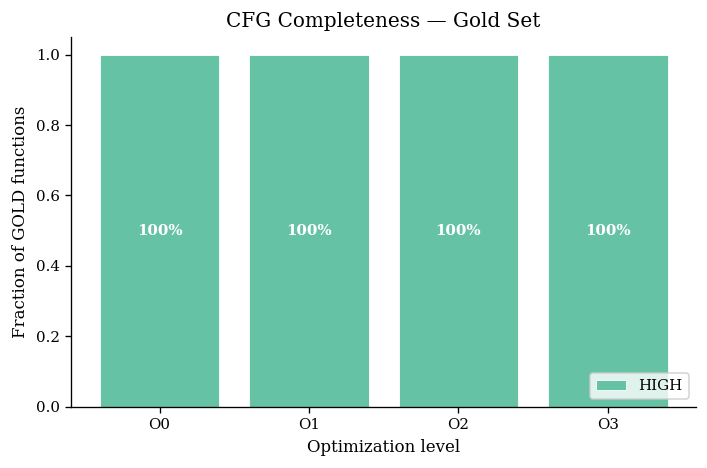

In [3]:
cfg_ct = pd.crosstab(df["opt"], df["cfg_completeness"], normalize="index")
cfg_order = [c for c in ["HIGH", "MEDIUM", "LOW"] if c in cfg_ct.columns]
cfg_ct = cfg_ct.reindex(columns=cfg_order, fill_value=0).reindex(OPT_LEVELS)

fig, ax = plt.subplots(figsize=(6, 4))
bottoms = np.zeros(len(OPT_LEVELS))
for level in cfg_order:
    vals = cfg_ct[level].values
    ax.bar(OPT_LEVELS, vals, bottom=bottoms, label=level, #type: ignore
           color=CFG_COLORS[level], edgecolor="white", linewidth=0.5)
    # Annotate percentages
    for j, (v, b) in enumerate(zip(vals, bottoms)):
        if v > 0.05:
            ax.text(j, b + v / 2, f"{v:.0%}", ha="center", va="center",
                    fontsize=9, color="white", fontweight="bold")
    bottoms += vals #type: ignore

ax.set_ylabel("Fraction of GOLD functions")
ax.set_xlabel("Optimization level")
ax.set_title("CFG Completeness — Gold Set")
ax.legend(loc="lower right")
ax.set_ylim(0, 1.05)
plt.tight_layout()
save_fig("cfg_completeness_gold")
plt.show()

---
## 2. Placeholder Type Rate (ECDF)

Empirical CDF of `placeholder_type_rate` for GOLD functions, stratified by opt level.
In stripped binaries, Ghidra infers types from usage patterns — higher optimization
levels use more aggressive register allocation, making type inference harder.

  -> saved ..\..\figures\decompiler_quality\placeholder_type_rate_ecdf.{pdf,png}


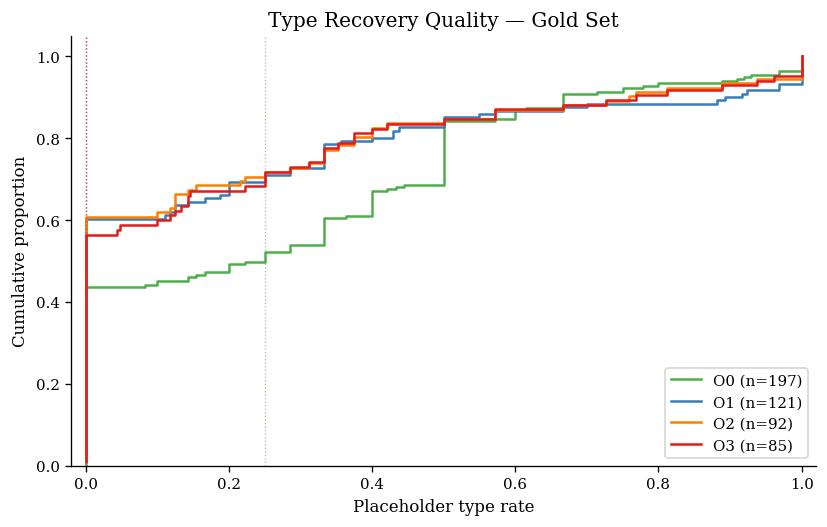

In [4]:
fig, ax = plt.subplots(figsize=(7, 4.5))

for opt in OPT_LEVELS:
    vals = df[df["opt"] == opt]["placeholder_type_rate"].dropna().sort_values()
    if len(vals) == 0:
        continue
    ecdf_y = np.arange(1, len(vals) + 1) / len(vals)
    ax.step(vals, ecdf_y, where="post", label=f"{opt} (n={len(vals)})",
            color=OPT_COLORS[opt], linewidth=1.5)
    # Median annotation
    median = vals.median()
    ax.axvline(x=median, color=OPT_COLORS[opt], linestyle=":", linewidth=0.8, alpha=0.6)

ax.set_xlabel("Placeholder type rate")
ax.set_ylabel("Cumulative proportion")
ax.set_title("Type Recovery Quality — Gold Set")
ax.legend(loc="lower right")
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(0, 1.05)
plt.tight_layout()
save_fig("placeholder_type_rate_ecdf")
plt.show()

Lower curves indicate better type recovery (more variables with resolved types).
Stripped binaries inherently lack type information — Ghidra must infer types
from register usage and calling conventions. A `placeholder_type_rate` of 0.0
means all variables have inferred concrete types; 1.0 means all are placeholders.

---
## 3. Code Complexity: Cyclomatic & Instruction-to-C Ratio

Box plots characterize the complexity distribution of the gold set.
- **Cyclomatic complexity** measures the number of linearly independent paths.
- **Instruction-to-C ratio** measures decompiler compression.

C:\Users\nico_\AppData\Local\Temp\ipykernel_149608\3407558545.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(cyc_data, labels=OPT_LEVELS, patch_artist=True, widths=0.5,
C:\Users\nico_\AppData\Local\Temp\ipykernel_149608\3407558545.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(itc_data, labels=OPT_LEVELS, patch_artist=True, widths=0.5,


  -> saved ..\..\figures\decompiler_quality\complexity_boxplots.{pdf,png}


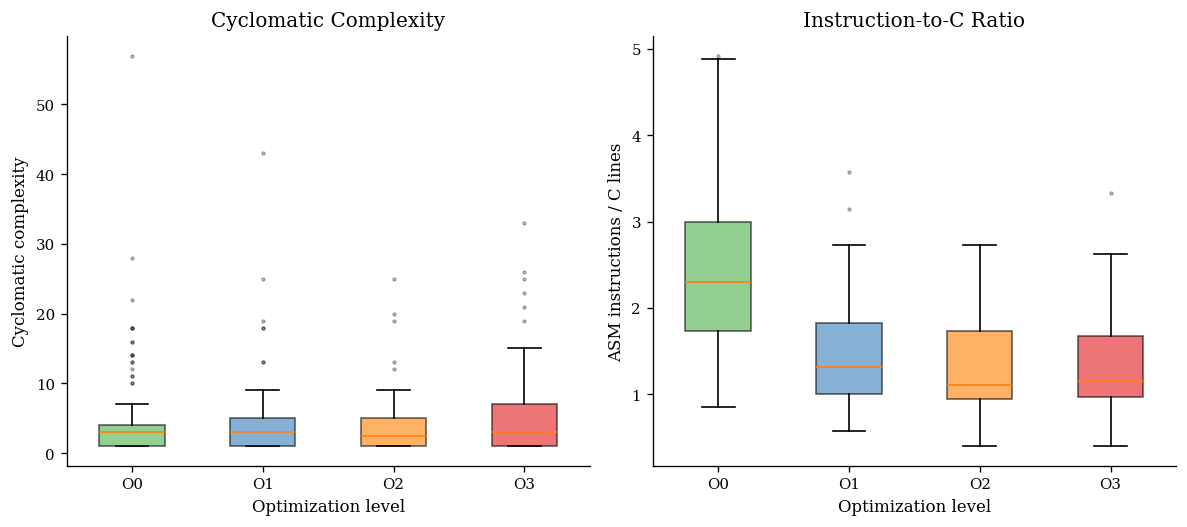

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# ── Cyclomatic complexity ─────────────────────────────────────────────
cyc_data = [df[df["opt"] == opt]["cyclomatic"].dropna().values for opt in OPT_LEVELS]
bp1 = ax1.boxplot(cyc_data, labels=OPT_LEVELS, patch_artist=True, widths=0.5,
                   showfliers=True, flierprops=dict(marker=".", markersize=3, alpha=0.4))
for patch, opt in zip(bp1["boxes"], OPT_LEVELS):
    patch.set_facecolor(OPT_COLORS[opt])
    patch.set_alpha(0.6)
ax1.set_ylabel("Cyclomatic complexity")
ax1.set_xlabel("Optimization level")
ax1.set_title("Cyclomatic Complexity")

# ── Instruction-to-C ratio ────────────────────────────────────────────
itc_data = [df[df["opt"] == opt]["insn_to_c_ratio"].dropna().values for opt in OPT_LEVELS]
bp2 = ax2.boxplot(itc_data, labels=OPT_LEVELS, patch_artist=True, widths=0.5,
                   showfliers=True, flierprops=dict(marker=".", markersize=3, alpha=0.4))
for patch, opt in zip(bp2["boxes"], OPT_LEVELS):
    patch.set_facecolor(OPT_COLORS[opt])
    patch.set_alpha(0.6)
ax2.set_ylabel("ASM instructions / C lines")
ax2.set_xlabel("Optimization level")
ax2.set_title("Instruction-to-C Ratio")

plt.tight_layout()
save_fig("complexity_boxplots")
plt.show()

### Key Takeaway

The gold set maintains **high decompiler quality across all optimization levels**.
CFG completeness is predominantly HIGH, confirming that Ghidra successfully
resolves control flow for the functions that pass the confidence gates.
The complexity distributions (cyclomatic and instruction-to-C ratio) are
stable across O0--O3, validating the gold set as suitable input for
LLM-based evaluation tasks.